## Import

In [1]:
import numpy as np

In [8]:
# MAE

def MAE(y, yhat):
    """_summary_

    Args:
        y (np.array): 정답값
        yhat (np.array): 예측값
    """
    return np.mean(np.abs(y-yhat))

In [10]:
y = np.array([2, 3])
yhat = np.array([2, 2])

MAE(y, yhat)

0.5

In [11]:
# MSE 

def MSE(y, yhat):
    """_summary_

    Args:
        y (_type_): _description_
        yhat (_type_): _description_
    """
    return np.mean(np.square(y-yhat))

# RMSE


In [ ]:
# MAPE(Mean Absolute Percentage Error)

abs((y-yhat)/y)

In [13]:
# !pip install pandas
# !pip install numpy
# # install sklearn
# !pip install scikit-learn
# !pip install tqdm
# !pip install fasteda
# !pip install seaborn

In [15]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
from fasteda import fast_eda as fe

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt


import gc
import warnings
warnings.filterwarnings(action='ignore') 

# Device & Path

In [5]:
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# torch.backends.mps.is_available()

In [2]:
# PATH
DATA_PATH  = '../DATA'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TRAIN_CSV  = os.path.join(DATA_PATH, 'train.csv')
SAMPLE_PATH = os.path.join(DATA_PATH, 'sample_submission.csv')

## Hyperparameter Setting

In [3]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':1,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':64,
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = True


seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [5]:
df_train = pd.read_csv(TRAIN_CSV)
df_ss = pd.read_csv(SAMPLE_PATH)
df_train

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200


## File Description
- [train.csv] - 2021년 6월 1일부터 2023년 5월 30일까지의 일별 시세정보


- [sample_submission.csv] [파일] - 제출 양식
종목코드 : 각 주식종목의 고유 코드
순위 : 거래행위 결정을 위한 수익률 순위
1~200위는 매수 (Long)
1801위부터 2000위는 공매도 (Short)


In [6]:
df_train.columns

Index(['일자', '종목코드', '종목명', '거래량', '시가', '고가', '저가', '종가'], dtype='object')

## columns 
1. '일자': 이 컬럼은 특정 거래가 발생한 날짜를 나타냅니다. "YYYY-MM-DD" 형식으로 표현됩니다.

2. '종목코드': 각각의 주식을 식별하는 고유한 코드입니다. 한국의 경우 종목코드는 대부분 6자리 숫자로 이루어져 있습니다. (ex - A060310)

3. '종목명': 주식의 공식 이름을 나타냅니다. 이 이름은 주로 회사의 이름을 반영하며, 시장에서 해당 주식을 찾을 때 사용됩니다.

4. '거래량': 특정 일자에 해당 주식이 거래된 총 주식 수를 나타냅니다. 거래량은 시장의 활동 수준과 관심도를 반영하는 중요한 지표입니다.

5. '시가': 주식 시장이 개장했을 때의 첫 거래 가격을 의미합니다. 이는 해당 날의 시장 흐름을 이해하는데 도움이 됩니다.

6. '고가': 특정 일자에 해당 주식이 거래된 가장 높은 가격을 나타냅니다.

7. '저가': 특정 일자에 해당 주식이 거래된 가장 낮은 가격을 나타냅니다.

8. '종가': 주식 시장이 마감했을 때의 마지막 거래 가격을 의미합니다. 종가는 해당 일의 주식 가격 변동을 반영하며, 이후의 시장 분석에 중요한 기준이 됩니다.

In [7]:
# change columns name
df = df_train.rename(columns={
    '일자': 'date',
    '종목코드': 'code',
    '종목명': 'name',
    '거래량': 'volume',
    '시가': 'open',
    '고가': 'high',
    '저가': 'low',
    '종가': 'close'
})
df.head(5)

,date,code,name,volume,open,high,low,close
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050


# Simple Summary


In [8]:
def summarize(df, file_name, n_rows_to_show=5):
    """Simply summarize the given DataFrame.
    
    Parameters:
        df: pd.DataFrame, raw DataFrame
        file_name: str, name of the file
        n_rows_to_show: int, number of rows to show 
    """
    print(f"=====Summary of {file_name}=====")
    print(f"Shape: {df.shape}")
    
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name='NaN Ratio').T
    print("NaN ratio:")
    display(nan_ratio)   
    
    display(df.head(n_rows_to_show))

In [9]:
summarize(df, 'train.csv')

=====Summary of train.csv=====
Shape: (988000, 8)
NaN ratio:


,date,code,name,volume,open,high,low,close
NaN Ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,date,code,name,volume,open,high,low,close
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050


In [10]:
df.drop(columns='date').describe()

,volume,open,high,low,close
count,9.880000e+05,9.880000e+05,9.880000e+05,9.880000e+05,9.880000e+05
mean,7.734265e+05,2.587701e+04,2.634938e+04,2.542335e+04,2.600283e+04
std,4.839914e+06,6.590845e+04,6.689822e+04,6.490307e+04,6.587082e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.500000e+01
25%,3.653900e+04,3.775000e+03,3.865000e+03,3.700000e+03,3.890000e+03
50%,1.140220e+05,8.630000e+03,8.810000e+03,8.470000e+03,8.700000e+03
75%,3.672998e+05,2.130000e+04,2.180000e+04,2.085000e+04,2.140000e+04
max,7.822434e+08,1.770000e+06,1.784000e+06,1.756000e+06,1.770000e+06


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988000 entries, 0 to 987999
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    988000 non-null  int64 
 1   code    988000 non-null  object
 2   name    988000 non-null  object
 3   volume  988000 non-null  int64 
 4   open    988000 non-null  int64 
 5   high    988000 non-null  int64 
 6   low     988000 non-null  int64 
 7   close   988000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 60.3+ MB


In [12]:
# datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.dtypes

date      datetime64[ns]
code              object
name              object
volume             int64
open               int64
high               int64
low                int64
close              int64
dtype: object

# 

## Fast EDA

DataFrame Head:


,volume,open,high,low,close
0,166690,2890,2970,2885,2920
1,63836,5860,5940,5750,5780
2,103691,35500,35600,34150,34400


DataFrame Tail:


,volume,open,high,low,close
987997,130664,1344,1395,1340,1370
987998,141932,9170,9260,9170,9200
987999,2611843,6410,8220,6300,8220


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(988000, 5)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988000 entries, 0 to 987999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   volume  988000 non-null  int64
 1   open    988000 non-null  int64
 2   high    988000 non-null  int64
 3   low     988000 non-null  int64
 4   close   988000 non-null  int64
dtypes: int64(5)
memory usage: 37.7 MB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
volume,988000,773426.518,114022,4839914.236,0,36539,114022,367299.75,782243419,40.243932,3299.510905
open,988000,25877.012,8630,65908.449,0,3775,8630,21300,1770000,8.330356,100.804784
high,988000,26349.384,8810,66898.216,0,3865,8810,21800,1784000,8.293444,99.728674
low,988000,25423.35,8470,64903.067,0,3700,8470,20850,1756000,8.353705,101.516805
close,988000,26002.83,8700,65870.824,85,3890,8700,21400,1770000,8.315905,100.410207


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



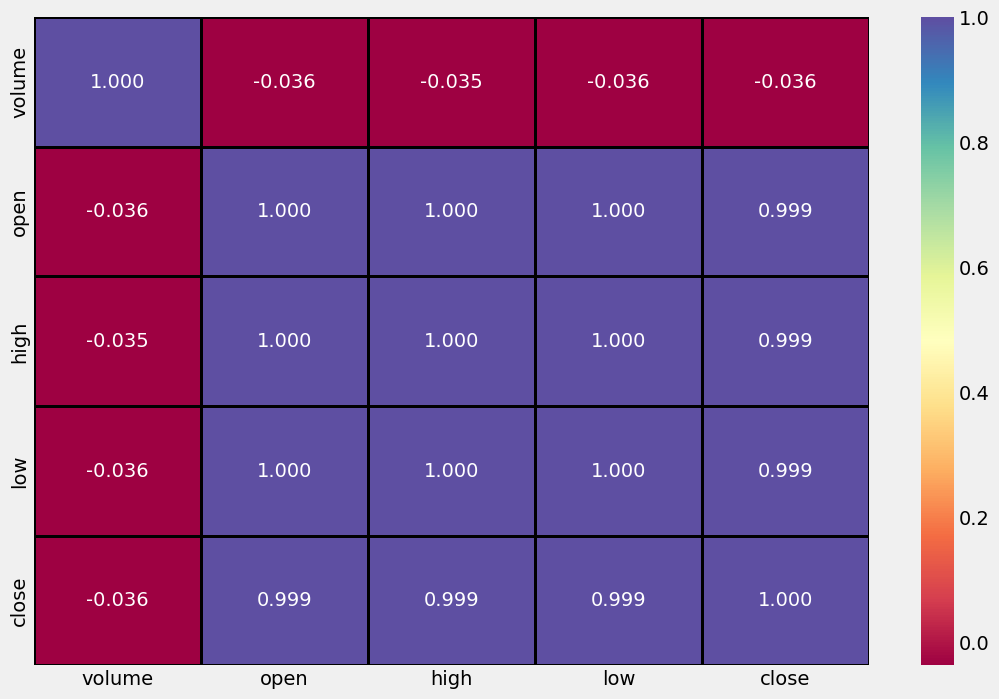

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



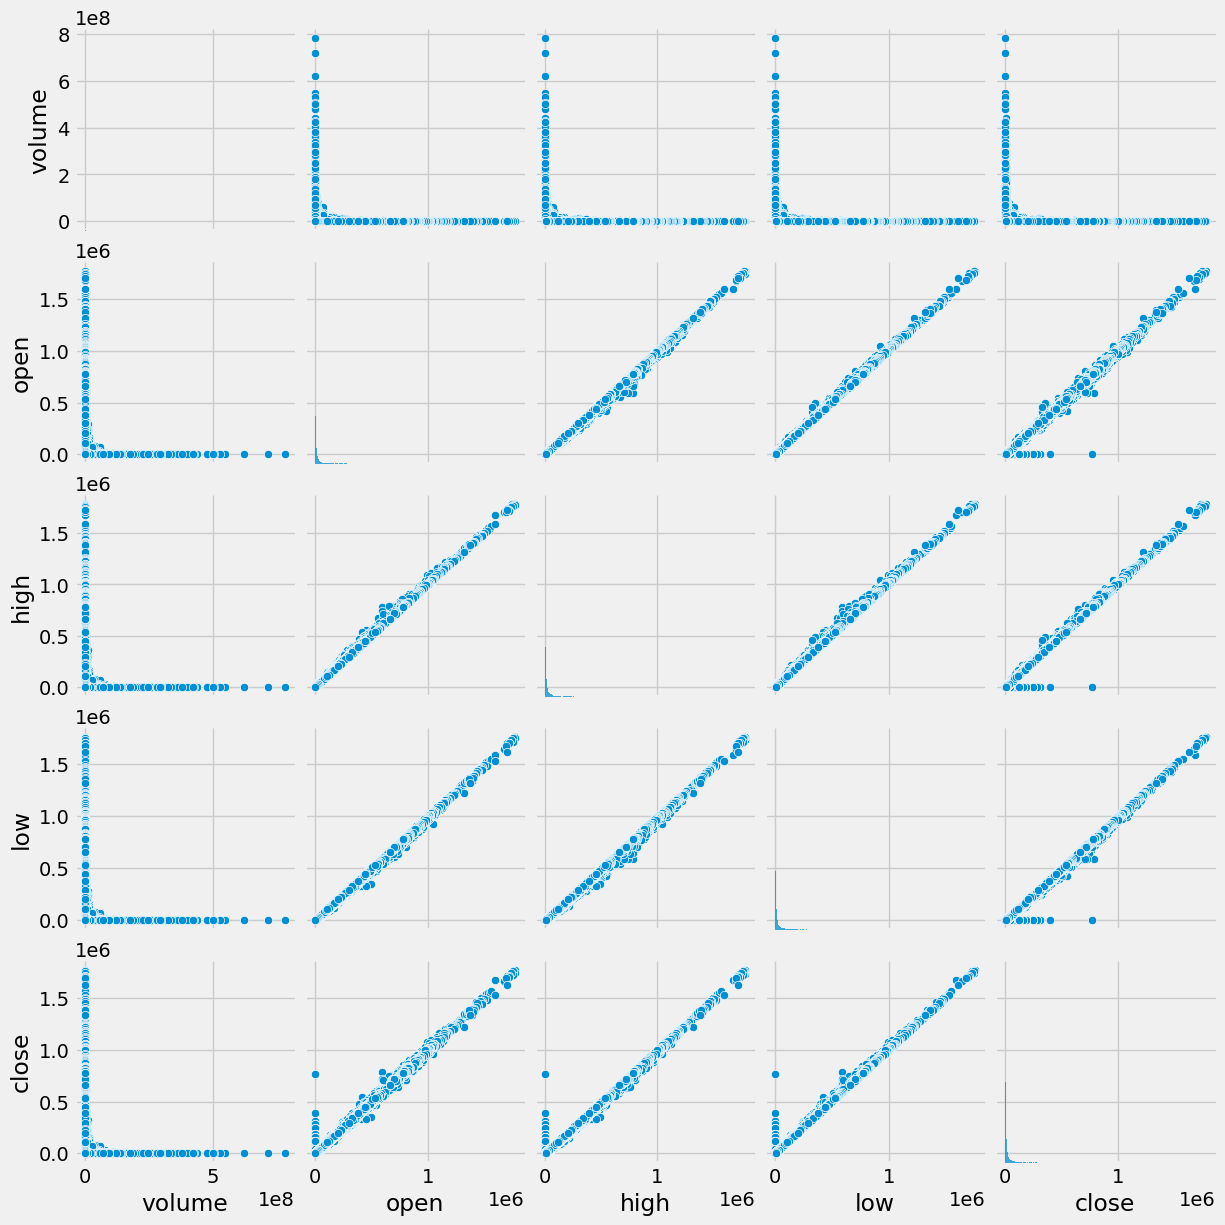

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



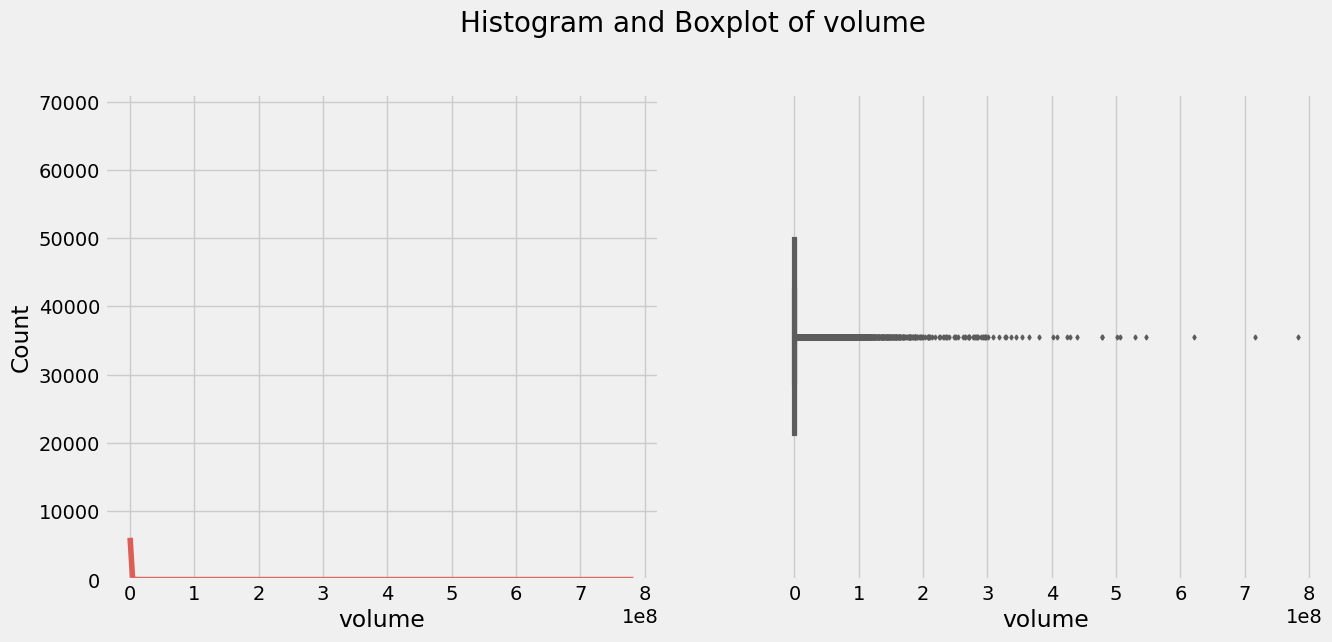

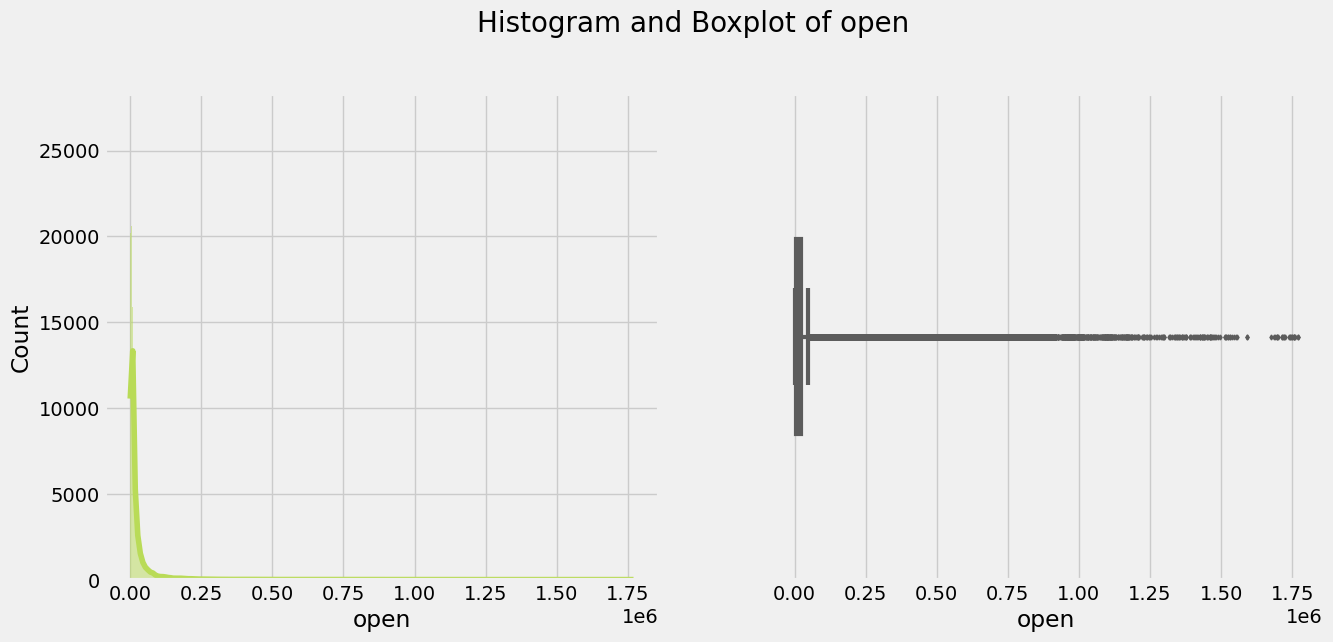

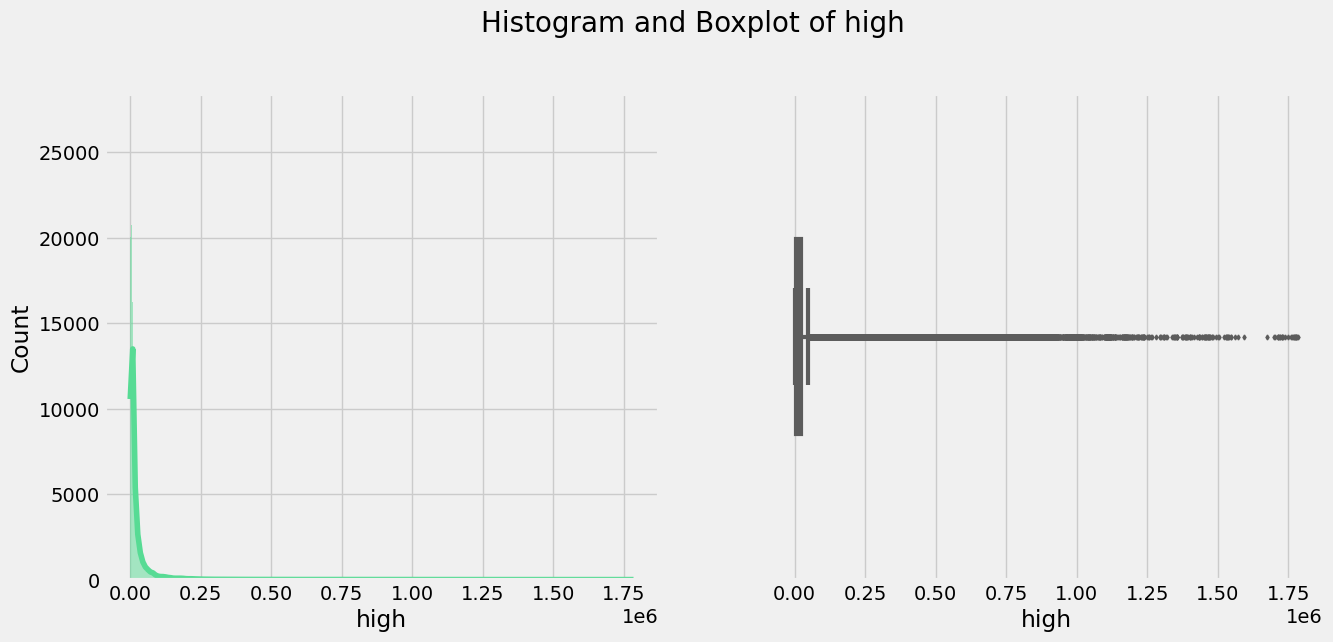

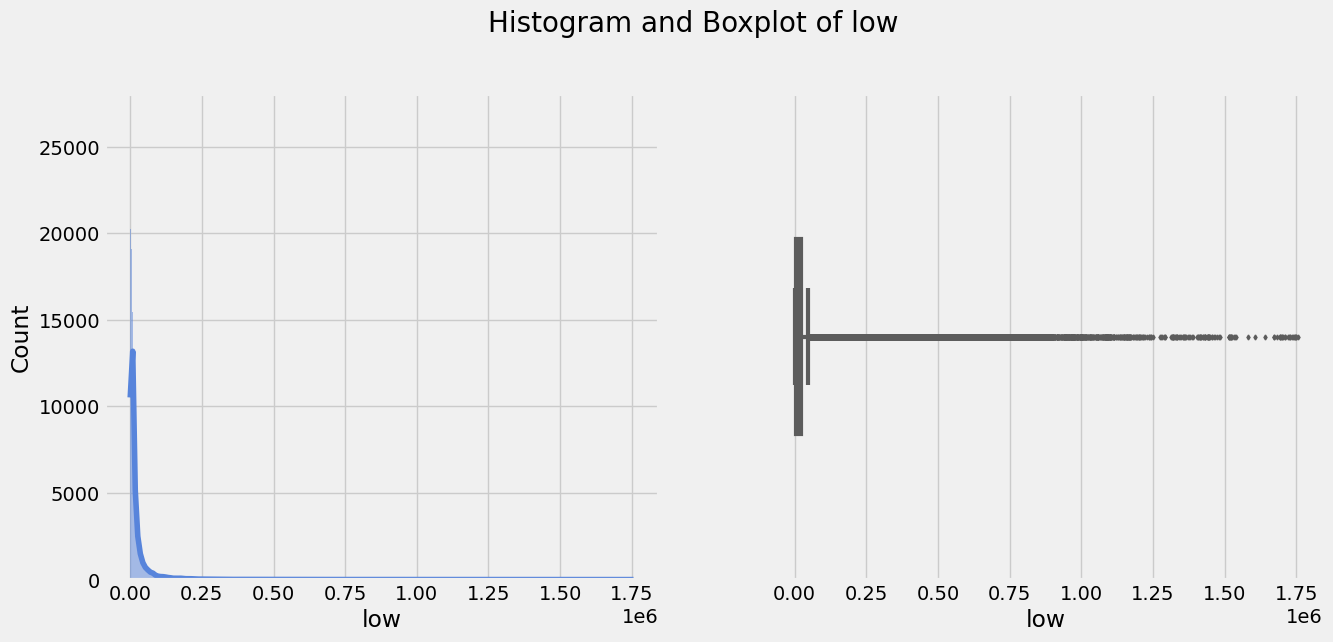

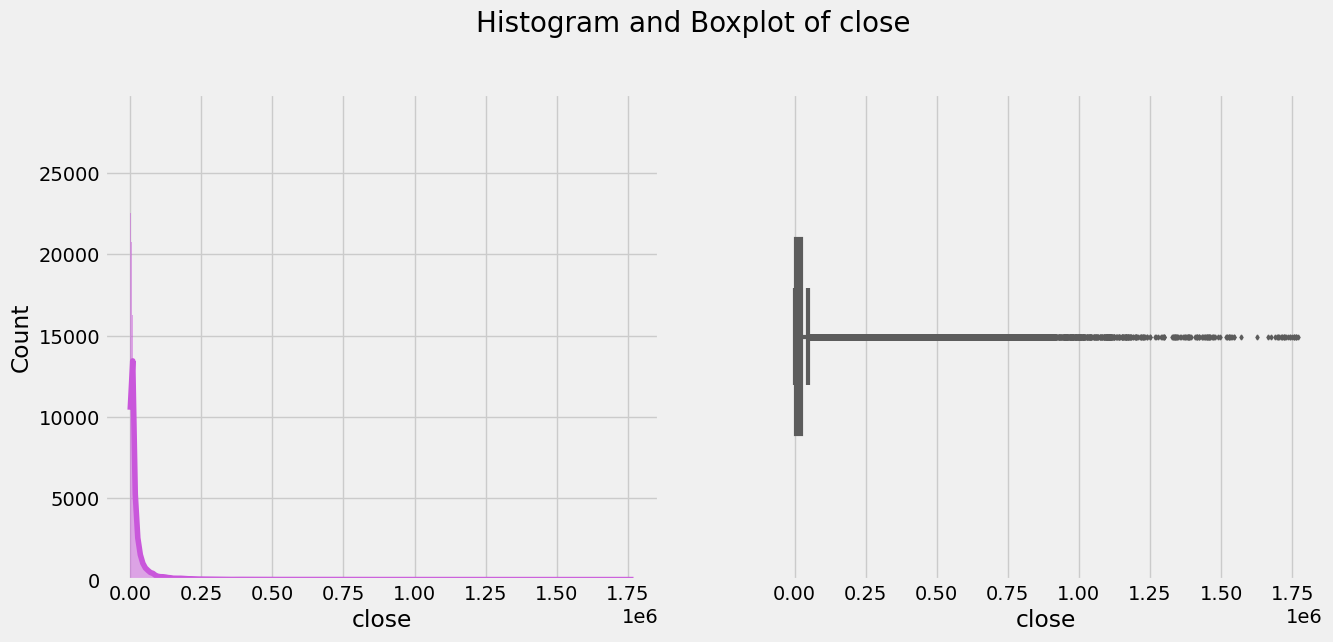

In [17]:
fe(df.drop(columns=['date', 'code','name']))

In [18]:
df_no_prices = df[df['close'].isna()]
print(f"Number of samples without prices: {len(df_no_prices)}")

Number of samples without prices: 0


In [19]:
# min max data
print(f'min of data is {df.date.min()}')
print(f'max of date is {df.date.max()}')
print(f'sum of days are {df.date.max()-df.date.min()}')

df_test = df[df['code']=='A238490'].copy()
# weekend
df_test['is_weekend'] = df_test['date'].apply(lambda x: x.weekday() >= 5)

# 'is_weekend' columns False count 
weekday_count = df_test[~df_test['is_weekend']].shape[0]

print(f"Number of weekdays: {weekday_count}")

min of data is 2021-06-01 00:00:00
max of date is 2023-05-30 00:00:00
sum of days are 728 days 00:00:00
Number of weekdays: 494


In [20]:
# maybe one code has 494 counts
df.code.value_counts()

A060310    494
A003460    494
A088390    494
A246960    494
A073490    494
          ... 
A301300    494
A053030    494
A035620    494
A018700    494
A238490    494
Name: code, Length: 2000, dtype: int64

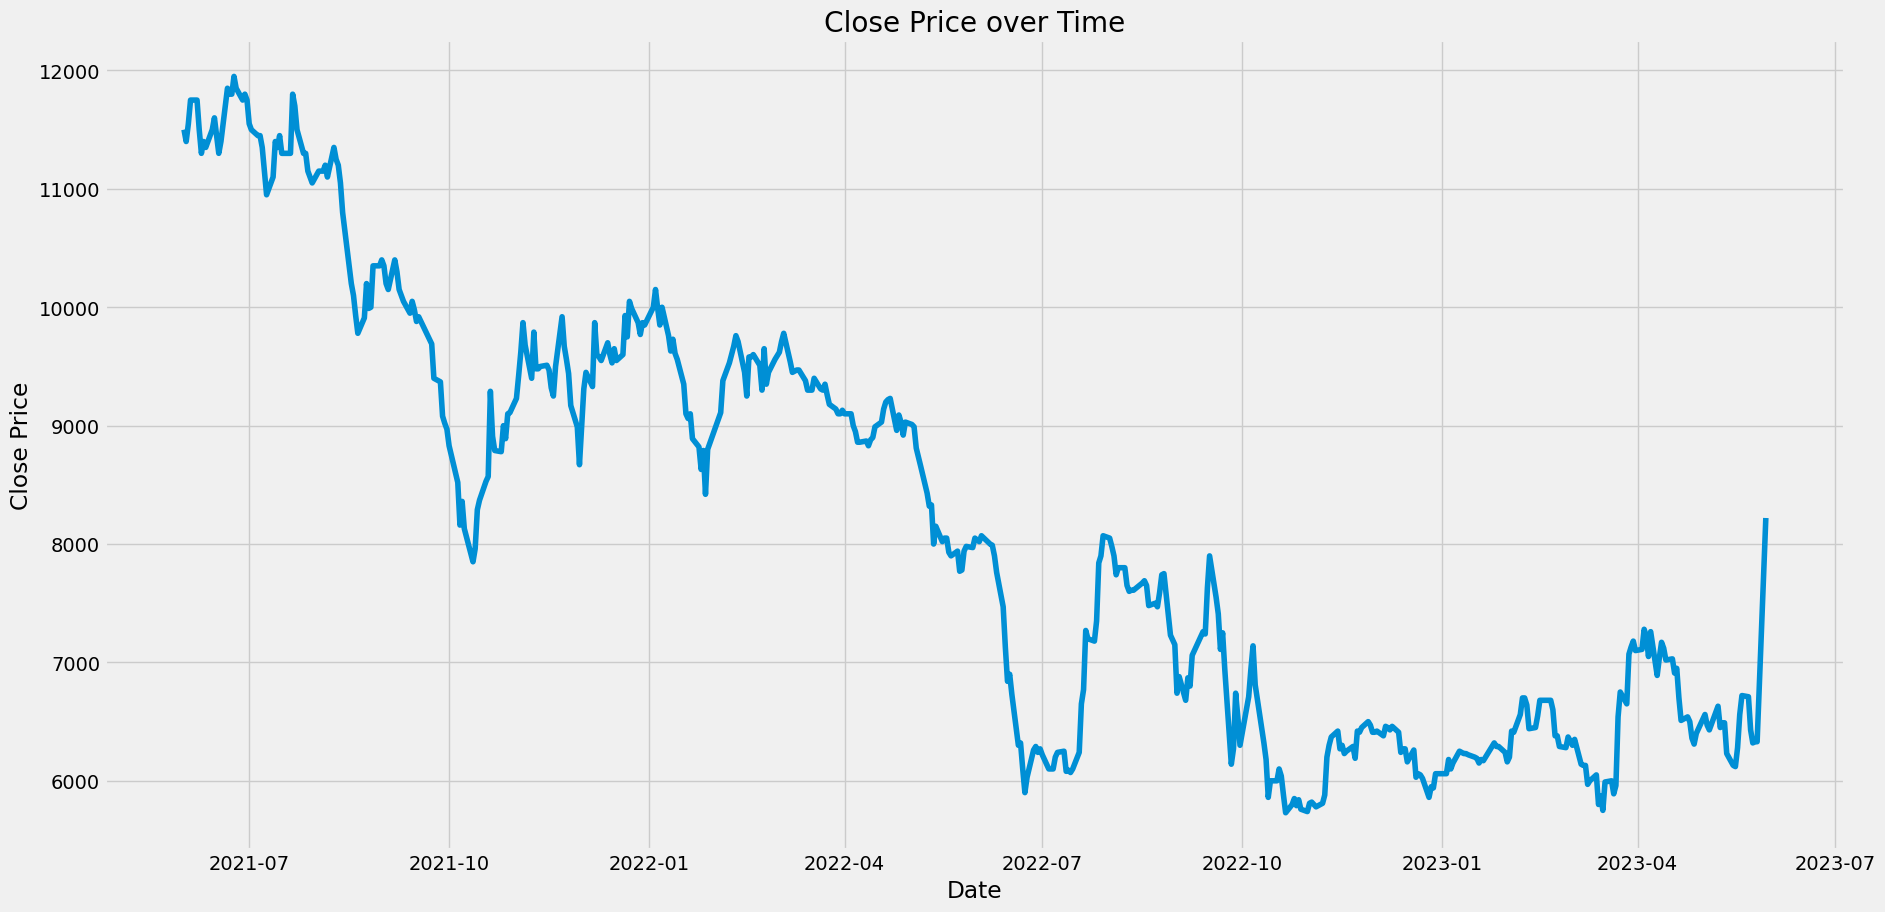

In [21]:
# df_test close plot
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(df_test['date'], df_test['close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price over Time')
plt.show()

In [22]:
df_price = df.pivot(index='date', columns='code', values='close')
df_price

code,A000020,A000040,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000180,A000210,A000220,A000230,A000240,A000250,A000270,A000300,A000320,A000370,A000390,A000400,A000430,A000440,A000480,A000490,A000500,A000520,A000540,A000590,A000640,A000650,A000660,A000670,A000680,A000700,A000720,A000760,A000810,A000850,A000860,A000880,A000890,A000910,A000950,A000970,A000990,A001000,A001020,A001040,A001060,A001070,A001080,A001120,A001130,A001140,A001200,A001230,A001250,A001260,A001270,A001290,A001340,A001360,A001380,A001390,A001430,A001440,A001450,A001460,A001470,A001500,A001510,A001520,A001530,A001540,A001550,A001560,A001570,A001620,A001630,A001680,A001720,A001740,A001750,A001780,A001790,A001800,A001810,A001820,A001840,A001880,A001940,A002020,A002030,A002100,A002140,A002150,A002170,A002200,A002210,A002220,A002230,A002240,A002290,A002310,A002320,A002350,A002360,A002380,A002390,A002410,A002450,A002460,A002600,A002620,A002630,A002680,A002690,A002700,A002710,A002720,A002760,A002780,A002790,A002800,A002810,A002840,A002880,A002900,A002920,A002960,A002990,A003000,A003010,A003030,A003060,A003070,A003080,A003090,A003100,A003120,A003160,A003200,A003220,A003230,A003240,A003280,A003300,A003310,A003350,A003380,A003410,A003460,A003470,A003480,A003490,A003520,A003530,A003540,A003550,A003560,A003570,A003580,A003610,A003620,A003650,A003670,A003690,A003720,A003780,A003800,A003830,A003850,A003920,A003960,A004000,A004020,A004060,A004080,A004090,A004100,A004140,A004150,A004170,A004250,A004270,A004310,A004360,A004370,A004380,A004410,A004430,A004440,A004450,A004490,A004540,A004560,A004590,A004650,A004690,A004700,A004710,A004720,A004770,A004780,A004800,A004830,A004840,A004870,A004890,A004910,A004920,A004960,A004970,A004980,A004990,A005010,A005070,A005090,A005110,A005160,A005180,A005250,A005290,A005300,A005320,A005360,A005380,A005390,A005420,A005430,A005440,A005490,A005500,A005610,A005670,A005680,A005690,A005710,A005720,A005740,A005750,A005800,A005810,A005820,A005830,A005850,A005860,A005870,A005880,...,A252500,A252990,A253450,A253590,A253840,A254120,A255220,A255440,A256150,A256630,A256840,A256940,A257370,A258610,A258830,A259630,A260660,A260930,A260970,A261200,A262260,A262840,A263020,A263050,A263540,A263600,A263690,A263700,A263720,A263750,A263770,A263800,A263810,A263860,A263920,A264450,A264660,A264850,A264900,A265520,A265560,A265740,A267250,A267260,A267270,A267290,A267320,A267790,A267850,A267980,A268280,A268600,A269620,A270520,A270660,A270870,A271560,A271980,A272110,A272210,A272290,A272450,A272550,A273060,A274090,A276730,A277070,A277410,A277810,A277880,A278280,A278650,A279600,A280360,A281740,A281820,A282330,A282690,A282880,A284620,A284740,A285130,A285490,A286750,A286940,A287410,A288330,A288620,A289010,A289080,A289220,A290120,A290380,A290520,A290550,A290650,A290670,A290690,A290720,A290740,A291230,A291650,A293480,A293490,A293580,A293780,A294090,A294140,A294570,A294630,A294870,A297090,A297570,A297890,A298000,A298020,A298040,A298050,A298060,A298380,A298540,A298690,A299030,A299170,A299660,A299900,A300080,A300120,A300720,A301300,A302430,A302440,A302550,A303030,A303360,A304100,A304840,A305090,A306040,A306200,A306620,A307180,A307280,A307750,A307870,A307930,A307950,A308100,A308170,A309930,A310200,A311390,A311690,A312610,A313760,A314130,A314930,A316140,A317120,A317240,A317330,A317400,A317530,A317690,A317770,A317830,A317850,A317870,A318000,A318010,A318020,A318410,A319400,A319660,A320000,A321260,A321550,A322000,A322180,A322310,A322510,A322780,A323280,A323990,A326030,A327260,A330350,A330860,A331520,A332290,A332370,A332570,A333430,A333620,A334970,A335810,A335890,A336060,A336260,A336370,A336570,A337930,A338220,A339770,A339950,A340440,A340570,A340930,A344820,A347700,A347740,A347770,A347860,A347890,A348030,A348150,A348210,A348350,A351320,A351330,A352480,A352700,A352770,A352820,A352940,A353190,A353200,A353810,A354200,A355150,A356860,A356890,A357230,A357550,A357780,A359090,A361390,A361610,A363250,A363260,A363280,A365590,A368770,A369370,A373200,A375500,A378850,A383220,A383310

In [23]:
Code = 'A000020' # Select Security Code

In [24]:
df

,date,code,name,volume,open,high,low,close
0,2021-06-01,A060310,3S,166690,2890,2970,2885,2920
1,2021-06-01,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,2021-06-01,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,2021-06-01,A054620,APS,462544,14600,14950,13800,14950
4,2021-06-01,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,2023-05-30,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,2023-05-30,A000540,흥국화재,50218,3250,3255,3195,3215
987997,2023-05-30,A003280,흥아해운,130664,1344,1395,1340,1370
987998,2023-05-30,A037440,희림,141932,9170,9260,9170,9200


In [25]:
cols = ['date', 'open', 'high', 'low', 'close', 'volume', 'code']
STOCK = df[df.code==Code][cols].set_index("date")
STOCK

,open,high,low,close,volume,code
date,,,,,,
2021-06-01,14700,14700,14450,14600,114966,A000020
2021-06-02,14700,14700,14450,14500,109559,A000020
2021-06-03,14550,14650,14450,14600,96158,A000020
2021-06-04,14600,14800,14550,14700,133900,A000020
2021-06-07,14800,15550,14750,15150,511140,A000020
...,...,...,...,...,...,...
2023-05-23,9160,9900,9160,9770,641524,A000020
2023-05-24,9770,9820,9550,9740,205243,A000020
2023-05-25,9660,10180,9660,10040,398326,A000020


In [26]:
from itertools import combinations, product

In [27]:
def absHighPass(df, absThresh):
    df.loc[:, ]
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

corr = df.corr()

In [28]:

STOCK.head()



,open,high,low,close,volume,code
date,,,,,,
2021-06-01,14700,14700,14450,14600,114966,A000020
2021-06-02,14700,14700,14450,14500,109559,A000020
2021-06-03,14550,14650,14450,14600,96158,A000020
2021-06-04,14600,14800,14550,14700,133900,A000020
2021-06-07,14800,15550,14750,15150,511140,A000020


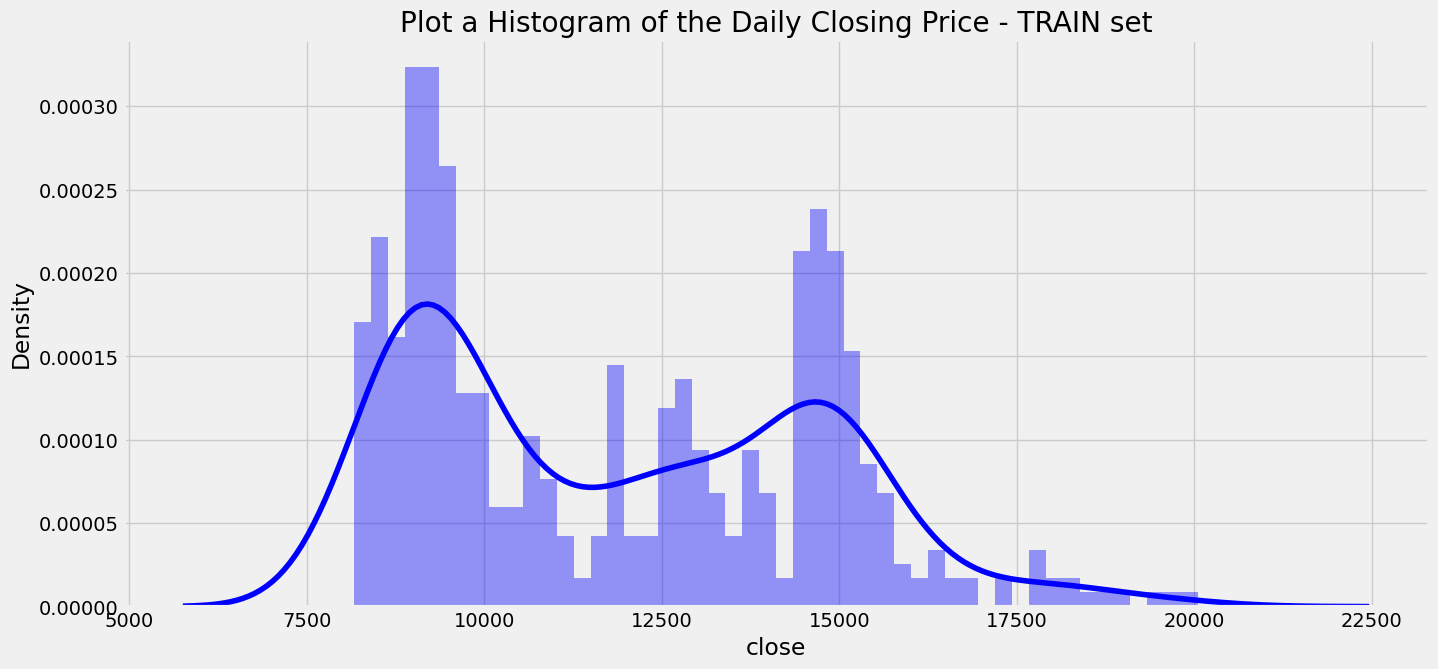

In [29]:
plt.figure(figsize=(15,7))
plt.title("Plot a Histogram of the Daily Closing Price - TRAIN set")
sns.distplot(STOCK['close'].dropna(), bins=50, color='blue');